# Libraries

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FuncFormatter
# from wordcloud import WordCloud
# import itertools
# import matplotlib as mpl
# from zipfile import ZipFile
# plt.style.use(['default'])

# Consts

In [72]:
# Lookup dict from general emotions to sentiment groupng
sentiment_lookup = {
    'sentiment_positive':['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'],
    'sentiment_negative':['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness'],
    'sentiment_ambiguous':['confusion', 'curiosity', 'realization', 'surprise'],
    'sentiment_neutral':['neutral']
}

# Lookup dict from general emotions to ekman groupng
ekman_lookup = {
    'ekman_joy':['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'],
    'ekman_anger':['anger', 'annoyance', 'disapproval'],
    'ekman_disgust':['disgust'],
    'ekman_fear':['fear', 'nervousness'],
    'ekman_sadness':['disappointment', 'embarrassment', 'grief', 'remorse', 'sadness'],
    'ekman_surprise':['confusion', 'curiosity', 'realization', 'surprise'],
    'ekman_neutral':['neutral']
}

# Lookup dict from topics to themes
theme2topic = {
    'Authorities': [3,4,11,12,15],
    'Daily Life Impact': [0,6,22],
    'Preventive measures': [8,13,17,20,21],
    'Outbreak and Variants': [1,9],
    'Cases and deaths': [14,19],
    'Breaking News': [2],
    'Vaccination': [16,18],
    'Education': [5],
    'Medical Care': [7],
    'Economy': [10]
}

# Lookup dict from topics to themes
topic2theme = {
    0:'Daily Life Impact',
    1:'Outbreak and Variants',
    2:'Breaking News',
    3:'Authorities',
    4:'Authorities',
    5:'Education',
    6:'Daily Life Impact',
    7:'Medical Care',
    8:'Preventive measures',
    9:'Outbreak and Variants',
    10:'Economy',
    11:'Authorities',
    12:'Authorities',
    13:'Preventive measures',
    14:'Cases and deaths',
    15:'Authorities',
    16:'Vaccination',
    17:'Preventive measures',
    18:'Vaccination',
    19:'Cases and deaths',
    20:'Preventive measures',
    21:'Preventive measures',
    22:'Daily Life Impact'    
}

# List of emotions
emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 
    'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

# List of tweet features besides emotions
comment_columns = [
    'tweet_id', 'conversation_id', 'author_id', 'in_reply_to_user_id', 'is_quote', 'created_at', 'geo',
    'lang', 'like_count', 'quote_count', 'reply_count', 'retweet_count', 'source', 'text'
]

# Load comments and News

In [ ]:
import pandas as pd
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt

# Get and process news -- uncomment this if generating news data frame
# news = pd.read_parquet('./../data/raw/news_tweets_em_scores.parquet')
# news_accounts = pd.read_csv('./../data/raw/news_accounts.csv')
# news_topics = pd.read_csv('./../data/processed/news_tweets_topics_290322.csv')
# news = news.merge(news_accounts[['author_id', 'country']])
# news = news.merge(news_topics[['tweet_id', 'num_topic']])
# news['created_at'] = pd.to_datetime(news.created_at, utc=True)
# news['emotion'] = news[emotions].idxmax(axis=1).values
# news['score'] = news[emotions].max(axis=1)
# news = news.drop(emotions, axis=1)
# news = news.sort_values('created_at').drop_duplicates('conversation_id', keep='first')
# news.to_csv('./../data/processed/news.csv', index=False)

# Get and process comments -- uncomment this if generating comments data frame
# comments_emotions = pd.read_parquet('./../data/raw/tweets_replies_em_scores.parquet', columns=emotions)
# comments_scores = comments_emotions.max(axis=1)
# comments_emotions = comments_emotions.idxmax(axis=1).values
# comments = pd.read_parquet('./../data/raw/tweets_replies_em_scores.parquet', columns=comment_columns)
# comments['emotion'] = comments_emotions
# comments['score'] = comments_scores
# comments = comments.merge(news.rename(
#     columns={'created_at':'news_at', 'emotion':'news_emotion', 'score':'news_score', 'num_topic':'topic'}
# )[['conversation_id', 'news_at', 'news_emotion', 'news_score', 'topic', 'country']])
# comments = comments.sort_values('created_at').drop_duplicates('tweet_id', keep='first')
# comments.to_csv('./../data/processed/comments.csv', index=False)

# Read comments and news dataframes
comments = pd.read_csv('./../data/processed/comments.csv')
news = pd.read_csv('./../data/processed/news.csv')

# Prepare comments dataframe to create figures
comments['news_at'] = pd.to_datetime(comments.news_at, utc=True)
comments['ds'] = comments.news_at.dt.date
comments['dsw'] = (comments['news_at'] + pd.offsets.Week(weekday=6)).dt.date
comments['dsm'] = pd.to_datetime(
    comments.news_at.dt.year.astype(str) + '-' + comments.news_at.dt.month.astype(str) + '-1'
)

# Create daily, weekly and montly comments consolidated view per emotion
monthly_emotions = comments.groupby('dsm').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='dsm', columns='emotion', values='emotion_prop')
weekly_emotions = comments.groupby('dsw').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='dsw', columns='emotion', values='emotion_prop')
daily_emotions = comments.groupby('ds').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='ds', columns='emotion', values='emotion_prop')

# Check available plt styles -- uncoment to check
# plt.style.available

In [74]:
comments['theme'] = comments.topic.apply(lambda x: topic2theme[x])

# Topic Analysis

In [7]:
import gensim
import pickle
from gensim.test.utils import datapath

# Load LDA model results
temp_file = datapath("topic_model_290322")
ldamallet = gensim.models.wrappers.LdaMallet.load(temp_file)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

# Load dictionary
with open('dictionary.pkl', 'rb') as handle:
    dictionary = pickle.load(handle)

# Top words per topic
n_topics = len(comments.topic.value_counts())
df_words = pd.DataFrame([])
topic_words = pd.DataFrame(columns=['topic', 'words'])
for topic in range(n_topics):
    tmp = pd.DataFrame(model.get_topic_terms(topic,35), columns=['wordid','imp'])
    tmp['topic'] = topic
    tmp['word'] = tmp.wordid.apply(lambda x: dictionary[x])
    df_words = pd.concat([df_words, tmp])
    topic_words.loc[len(topic_words)] = [topic, (list(tmp.word.values))]
    
# Topic distribution per tweet
topic_details = pd.read_csv('./../data/processed/news_tweets_topics_290322.csv')

# Top tweets per topic -- uncomment this and select a topic number
# k = 14
# tmp = topic_details[topic_details.num_topic==k].sort_values('topic_'+str(k)).head(5).tweet_id.values
# news[(news.tweet_id.isin(tmp))].text.values

# Top terms per topic -- uncomment this and select a topic number

# Distribution of emotions per day

### Daily sentiment -- 14-day avg

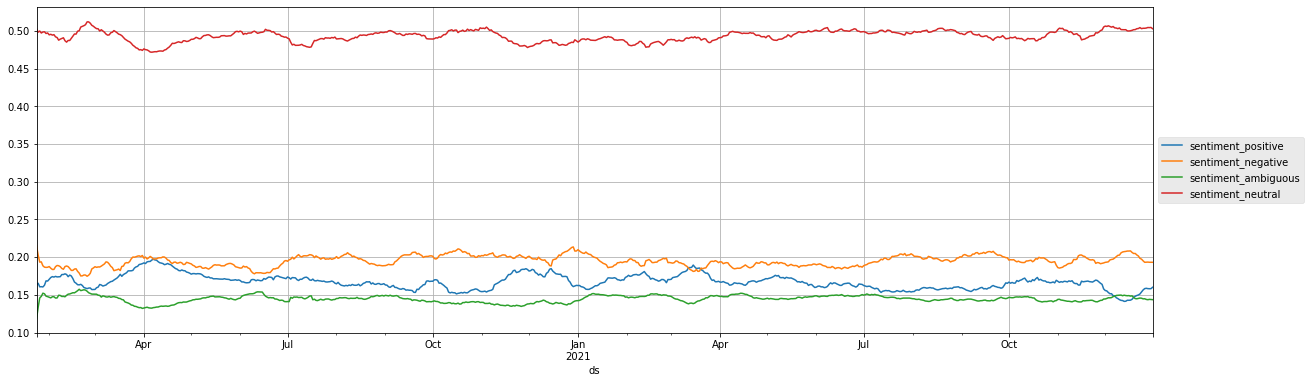

In [50]:
daily_emotions.index = pd.to_datetime(daily_emotions.index)
for s, v in sentiment_lookup.items():
    daily_emotions[s] = daily_emotions[v].sum(axis=1)

fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    daily_emotions[sentiment_lookup.keys()].rolling('14d').mean().plot.line(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Daily ekman -- 14-day avg

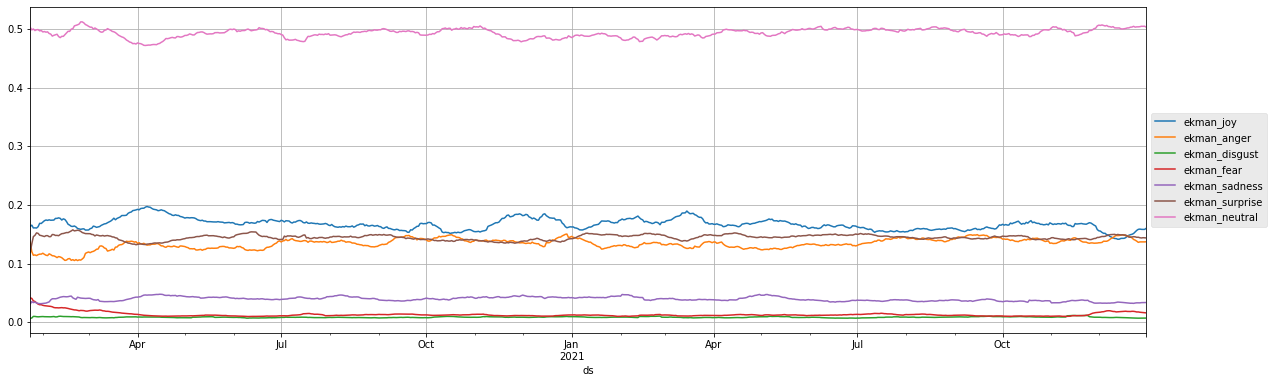

In [51]:
daily_emotions.index = pd.to_datetime(daily_emotions.index)
for s, v in ekman_lookup.items():
    daily_emotions[s] = daily_emotions[v].sum(axis=1)

fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    daily_emotions[ekman_lookup.keys()].rolling('14d').mean().plot.line(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Daily Emotions -- 14-day avg

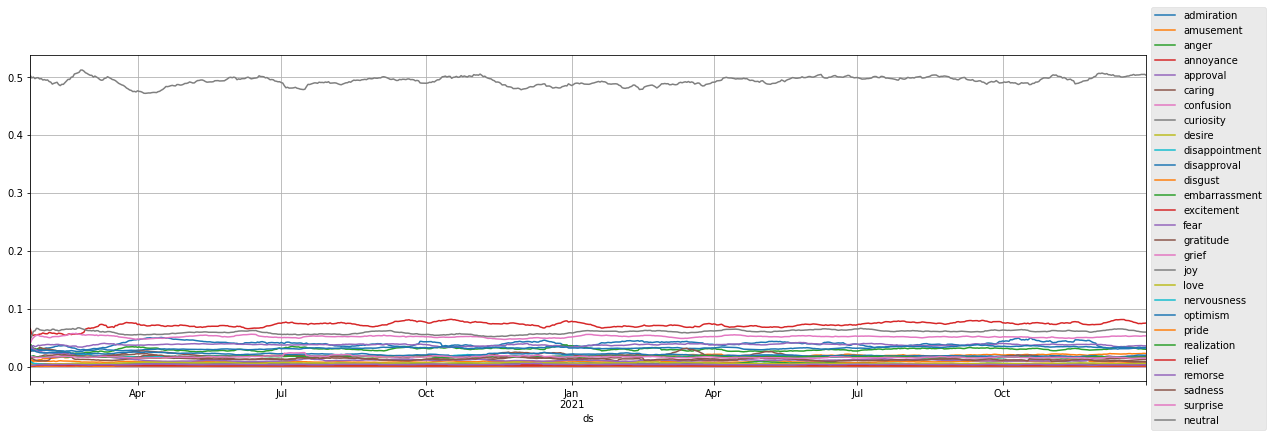

In [52]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    daily_emotions[emotions].rolling('14d').mean().plot.line(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Daily Emotions (except neutral) -- 14-day avg

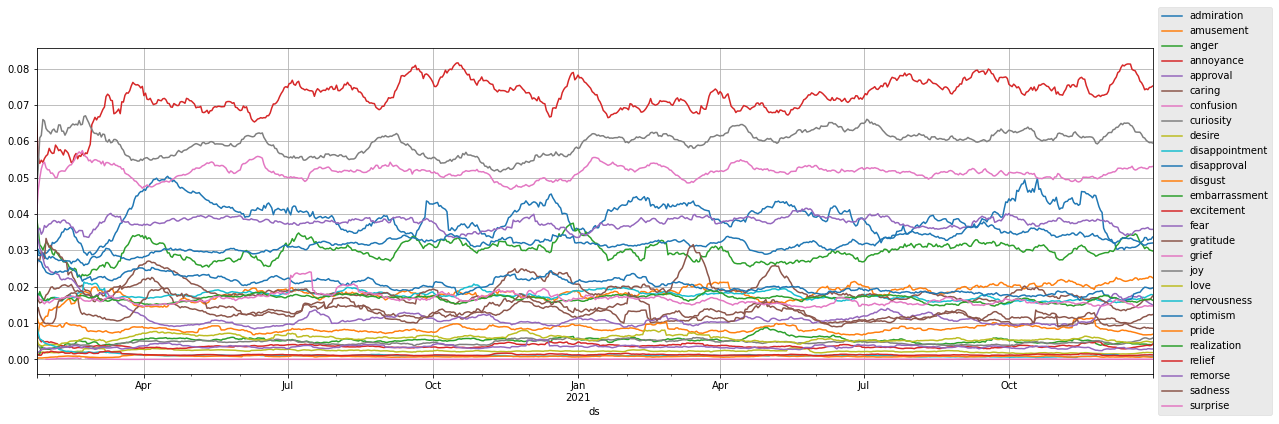

In [59]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = [emotion for emotion in emotions if (emotion not in ['neutral'])]
    daily_emotions[e].rolling('14d').mean().plot.line(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Daily Emotions (except neutral and with less frequent emotions mapped to 'other') -- 14-day avg

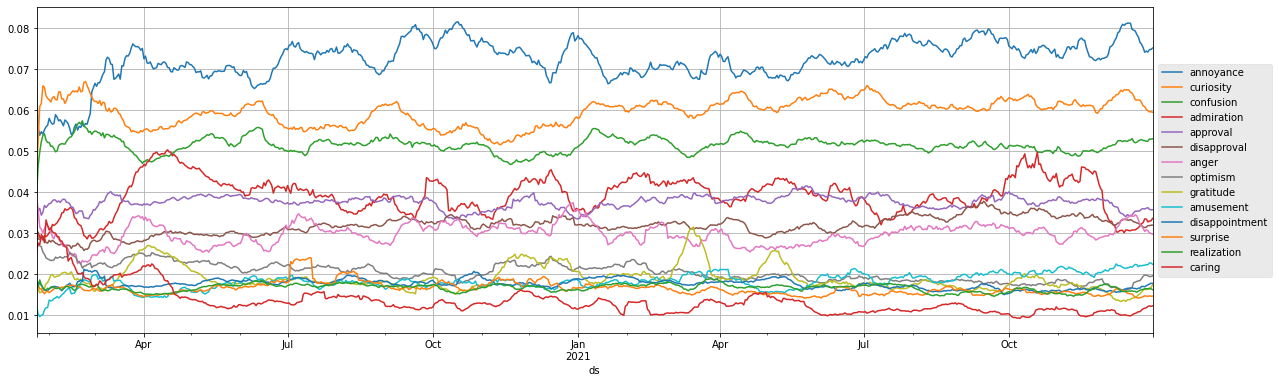

In [67]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = comments[comments.emotion!='neutral'].emotion.value_counts(normalize=True).cumsum()
    e = e[e < 0.9]
    e = list(e.index)
    daily_emotions[e].rolling('14d').mean().plot.line(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Distribution of emotions per theme

In [89]:
theme_emotions = comments.groupby('theme').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='theme', columns='emotion', values='emotion_prop')
ordered_emotions = comments.emotion.value_counts().index

for s, v in sentiment_lookup.items():
    theme_emotions[s] = theme_emotions[v].sum(axis=1)

for s, v in ekman_lookup.items():
    theme_emotions[s] = theme_emotions[v].sum(axis=1)

### Theme vs Sentiment

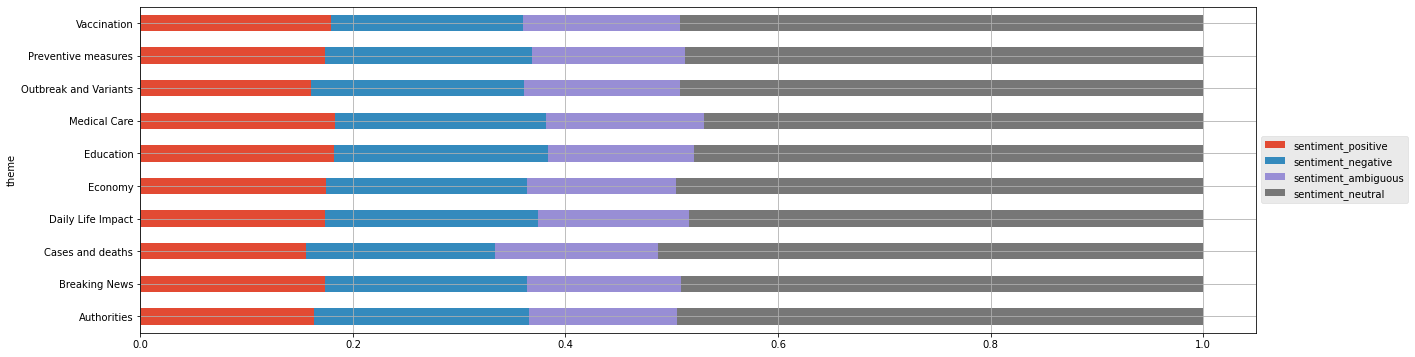

In [88]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    theme_emotions[sentiment_lookup.keys()].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Theme vs Ekman

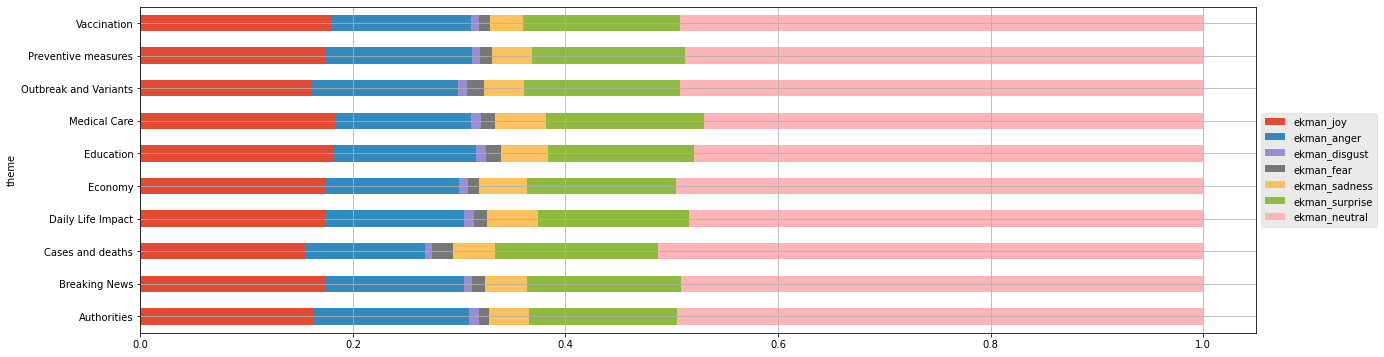

In [90]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    theme_emotions[ekman_lookup.keys()].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Theme vs Emotion

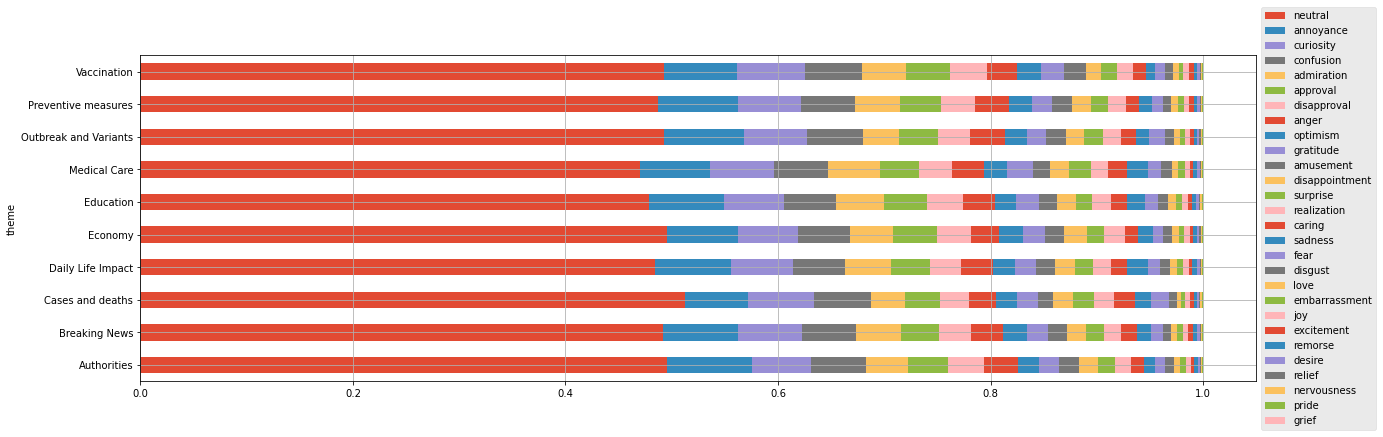

In [85]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    theme_emotions[ordered_emotions].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Theme vs Emotion (except neutral)

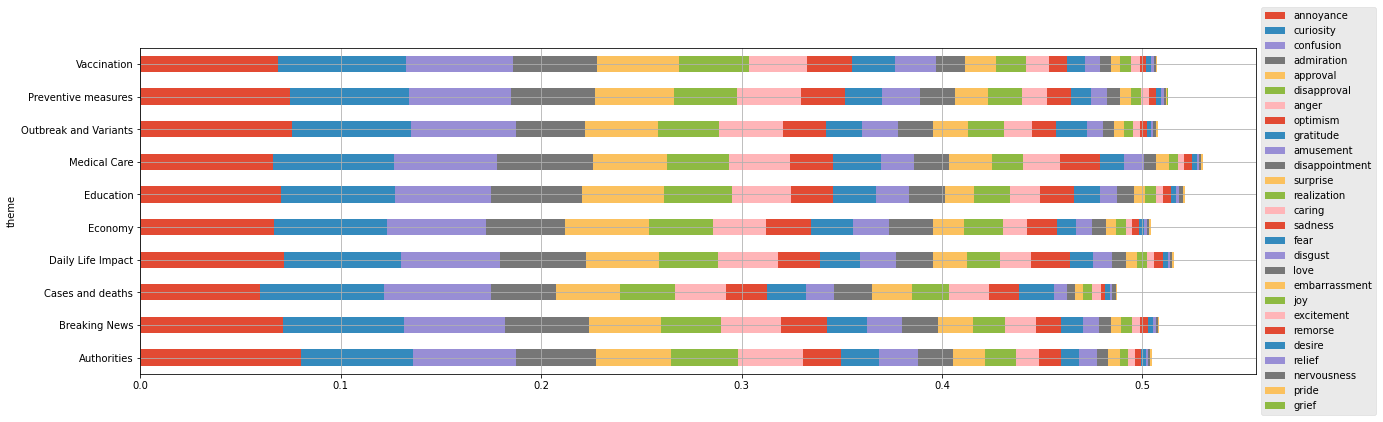

In [86]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = [emotion for emotion in ordered_emotions if (emotion not in ['neutral'])]
    theme_emotions[e].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Theme vs Emotion (most relevant, except neutral)

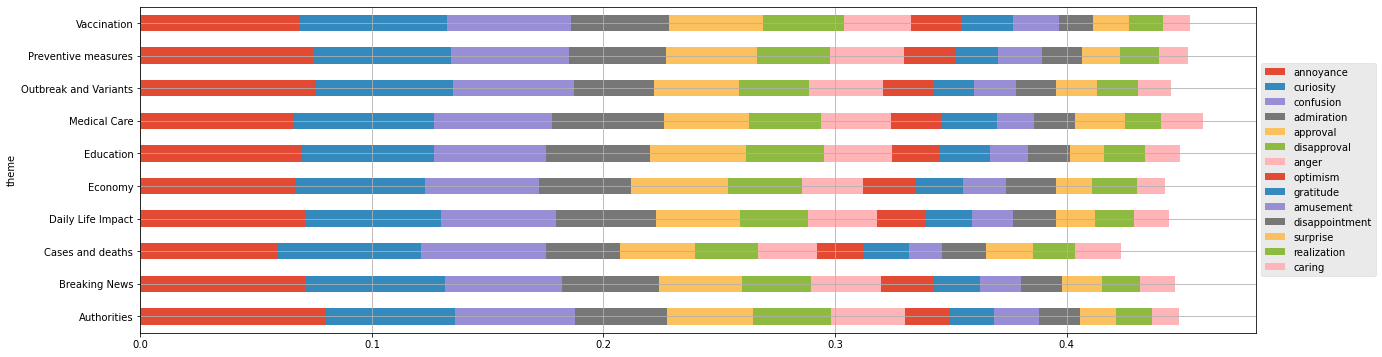

In [98]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = comments[comments.emotion!='neutral'].emotion.value_counts(normalize=True).cumsum()
    e = e[e < 0.9]
    e = list(e.index)
    theme_emotions[e].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Distribution of emotions per country

In [99]:
country_emotions = comments.groupby('country').emotion.value_counts(normalize=True).rename('emotion_prop').reset_index().pivot(index='country', columns='emotion', values='emotion_prop')
ordered_emotions = comments.emotion.value_counts().index

for s, v in sentiment_lookup.items():
    country_emotions[s] = country_emotions[v].sum(axis=1)

for s, v in ekman_lookup.items():
    country_emotions[s] = country_emotions[v].sum(axis=1)

### Country vs Sentiment

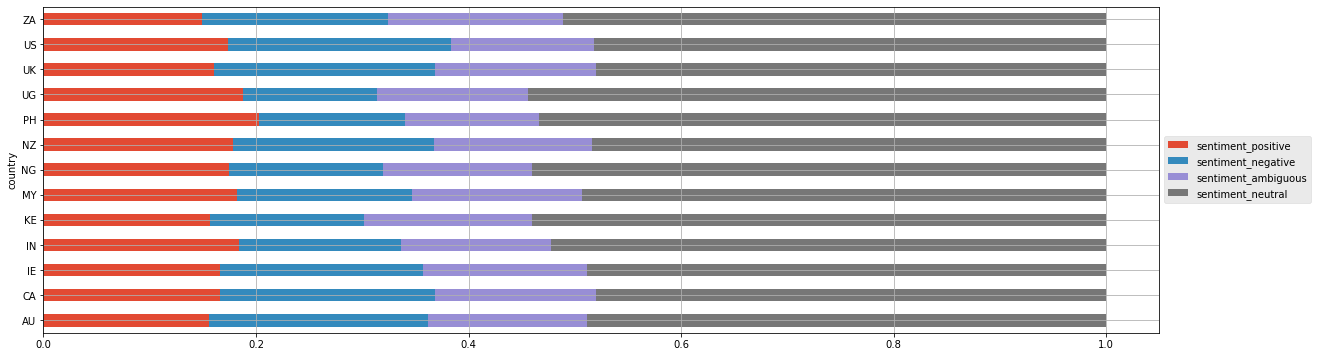

In [100]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    country_emotions[sentiment_lookup.keys()].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Country vs Ekman

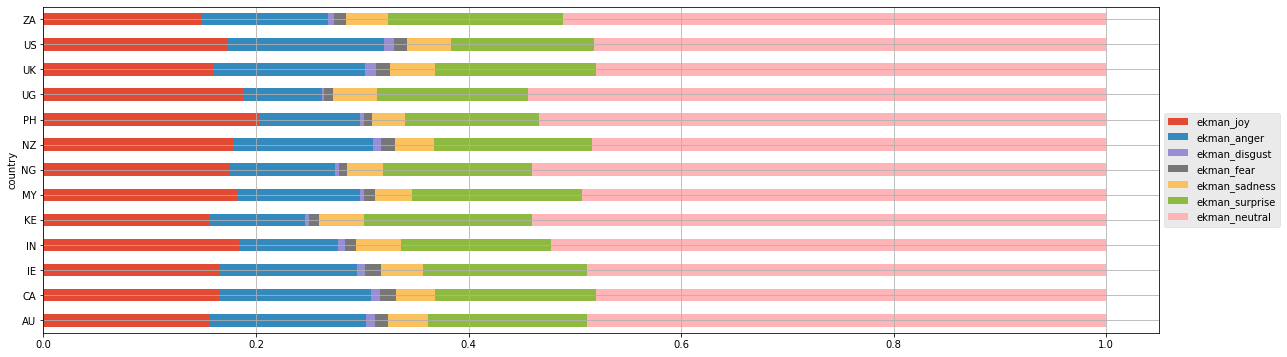

In [101]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    country_emotions[ekman_lookup.keys()].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Country vs Emotion

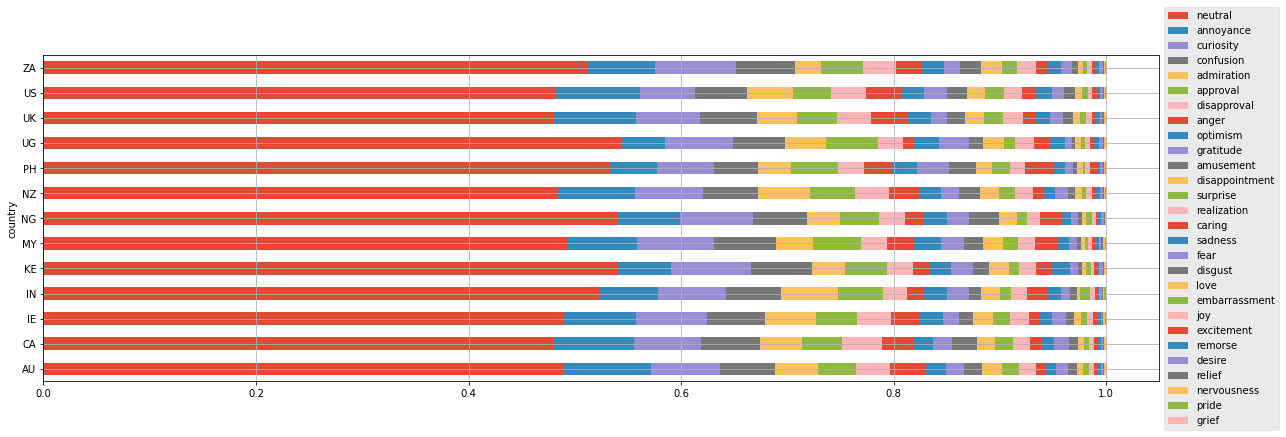

In [102]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    country_emotions[ordered_emotions].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Country vs Emotion (except neutral)

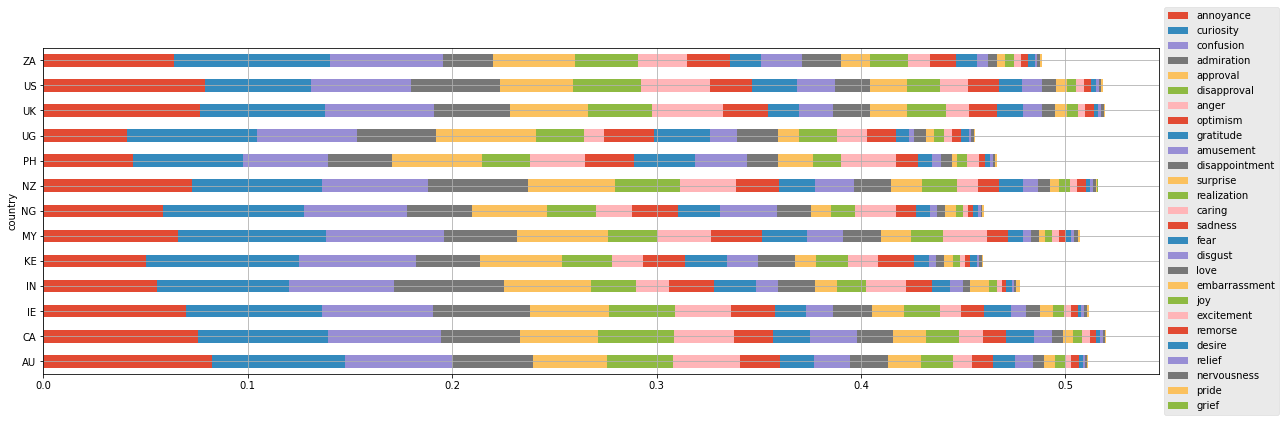

In [103]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = [emotion for emotion in ordered_emotions if (emotion not in ['neutral'])]
    country_emotions[e].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Country vs Emotion (most relevant, except neutral)

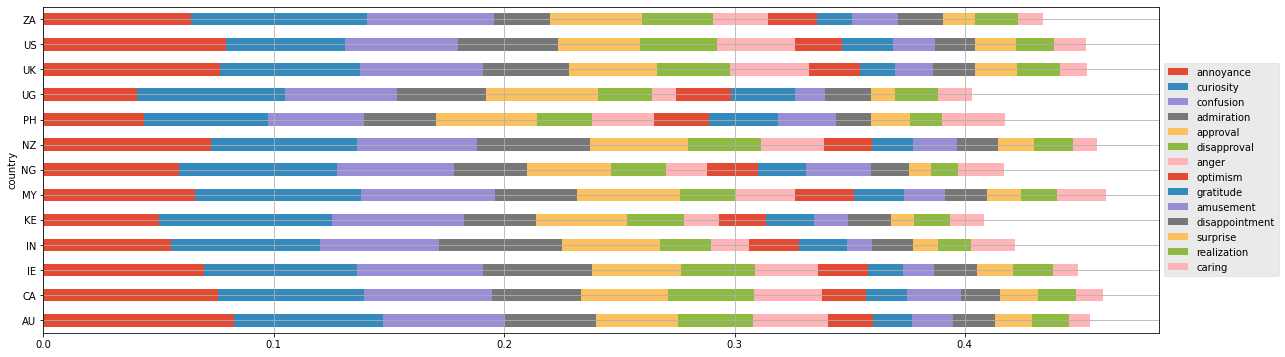

In [104]:
fig, ax = plt.subplots(1,1,figsize=(20, 6), sharex=True)
with plt.style.context(['ggplot']):
    e = comments[comments.emotion!='neutral'].emotion.value_counts(normalize=True).cumsum()
    e = e[e < 0.9]
    e = list(e.index)
    country_emotions[e].plot.barh(ax=ax, stacked=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))